# Imports

CHECK LIST :

-Travailler les normalisations (BABA)

-Fonction pour aller chercher les images avec le plus de villes(YANN)

-DATA AUGMENTATION A DISCUTER (FONCTIONS ET LES CLASSES BALANCE) (YANN)

-CHOISIR METRIQUES

-SEARCH MODELS IMPLEMENTATION + ARCHI CODE (UNET, SEG, OTHER) (BABA) NOTEBOOK + CMD

-CROSS VAL (AFTER)

In [2]:
!pip install timm
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.5 MB/s eta 0:00:00


In [7]:
from pathlib import Path
from collections import OrderedDict
import numpy as np
from tifffile import TiffFile
from torch.utils.data import Dataset
import random
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import RandomVerticalFlip
from torchvision.transforms import RandomHorizontalFlip
from torchvision.transforms import Normalize
from torchvision.transforms import RandomRotation
import torchvision.transforms as transforms
from timeit import default_timer as timer
import os
import sys
import time
import argparse
import datetime
import copy
from torchvision.transforms import ToPILImage
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os

import torch

from transformers import SegformerModel, SegformerConfig
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

# Utils from the github project

In [27]:
class LandCoverData():
    """Class to represent the S2GLC Land Cover Dataset for the challenge,
    with useful metadata and statistics.
    """
    # image size of the images and label masks
    IMG_SIZE = 256
    # the images are RGB+NIR (4 channels)
    N_CHANNELS = 4
    # we have 9 classes + a 'no_data' class for pixels with no labels (absent in the dataset)
    N_CLASSES = 10
    CLASSES = [
        'no_data',
        'clouds',
        'artificial',
        'cultivated',
        'broadleaf',
        'coniferous',
        'herbaceous',
        'natural',
        'snow',
        'water'
    ]
    # classes to ignore because they are not relevant. "no_data" refers to pixels without
    # a proper class, but it is absent in the dataset; "clouds" class is not relevant, it
    # is not a proper land cover type and images and masks do not exactly match in time.
    IGNORED_CLASSES_IDX = [0, 1]

    # The training dataset contains 18491 images and masks
    # The test dataset contains 5043 images and masks
    TRAINSET_SIZE = 18491
    TESTSET_SIZE = 5043

    # for visualization of the masks: classes indices and RGB colors
    CLASSES_COLORPALETTE = {
        0: [0,0,0],
        1: [255,25,236],
        2: [215,25,28],
        3: [211,154,92],
        4: [33,115,55],
        5: [21,75,35],
        6: [118,209,93],
        7: [130,130,130],
        8: [255,255,255],
        9: [43,61,255]
        }
    CLASSES_COLORPALETTE = {c: np.asarray(color) for (c, color) in CLASSES_COLORPALETTE.items()}

    # statistics
    # the pixel class counts in the training set
    TRAIN_CLASS_COUNTS = np.array(
        [0, 20643, 60971025, 404760981, 277012377, 96473046, 333407133, 9775295, 1071, 29404605]
    )
    # the minimum and maximum value of image pixels in the training set
    TRAIN_PIXELS_MIN = 1
    TRAIN_PIXELS_MAX = 24356

In [5]:
def numpy_parse_image_mask(image_path,N_CHANNELS=4):
    """Load an image and its segmentation mask as numpy arrays and returning a tuple
    Args:
        image_path : path to image
    Returns:
        (numpy.array[uint16], numpy.array[uint8]): the image and mask arrays
    """
    # image_path = Path(image_path)
    # get mask path from image path:
    # image should be in a images/<image_id>.tif subfolder, while the mask is at masks/<image_id>.tif
    mask_path = image_path.replace("images","masks")
    with TiffFile(image_path) as tifi, TiffFile(mask_path) as tifm:
        image = tifi.asarray()[:, :, :N_CHANNELS]
        mask = tifm.asarray()
    return image, mask


# Dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


New TEST


In [28]:
class LandscapeData(Dataset):

    N_CHANNELS = LandCoverData.N_CHANNELS
    IMG_SIZE = LandCoverData.IMG_SIZE
    TRAIN_PIXELS_MAX = LandCoverData.TRAIN_PIXELS_MAX

    def __init__(self, data_folder, transform=ToTensor()):
        self.data_folder = data_folder
        self.transform = transform

        # Liste des noms de fichiers dans les dossiers
        image_files = os.listdir(os.path.join(data_folder, 'images'))

        # Séparation des données en ensembles d'entraînement, de validation et de test
        train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
        train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

        # Utilisez numpy_parse_image_mask pour charger les images et les masques
        self.train_data = [numpy_parse_image_mask(os.path.join(data_folder, 'images', filename),self.N_CHANNELS) for filename in train_files]
        self.val_data = [numpy_parse_image_mask(os.path.join(data_folder, 'images', filename),self.N_CHANNELS) for filename in val_files]
        self.test_data = [numpy_parse_image_mask(os.path.join(data_folder, 'images', filename),self.N_CHANNELS) for filename in test_files]

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        image, label = self.train_data[idx]
        channels, height, width = self.N_CHANNELS, self.IMG_SIZE, self.IMG_SIZE

        # Normalisez les valeurs des pixels dans la plage [0, 1]
        image = image.astype("float32") / self.TRAIN_PIXELS_MAX
        label = label.astype("int64")

        image = self.transform(image)

        # Modifiez la transformation pour le masque
        label = torch.tensor(label, dtype=torch.int64)  # Convertir en torch.Tensor
        label = label.squeeze()  # Supprimer la dimension ajoutée

        return image, label


# Exemple d'utilisation
data_folder = "/content/drive/MyDrive/small_dataset"
dataset = LandscapeData(data_folder, transform=transforms.Compose([transforms.ToTensor()]))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

data_loaders = {'train': train_loader, 'val': val_loader}


images, masks = next(iter(train_loader))
print("Image : ", images.shape)
print("masks : ", masks.shape)


Image :  torch.Size([4, 4, 256, 256])
masks :  torch.Size([4, 256, 256])


In [29]:
config = SegformerConfig(
    num_labels=10,
    num_channels=4,
    patch_sizes = [3, 2, 2, 2]
)

model = SegformerForSemanticSegmentation(config)

# define model
#model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         #num_labels=10,
#)


# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



# Training
def train_model(model, optimizer, num_epochs):
    since = time.time()
    train_losses = []
    val_losses = []
    dataset_sizes = {phase: len(data_loaders[phase].dataset) for phase in ['train', 'val']}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-" * 10)

        running_loss = {'train': 0.0, 'val': 0.0}

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for inputs, targets in data_loaders[phase]:
                pixel_values = inputs.to('cuda:0')
                labels = targets.to('cuda:0')
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(pixel_values=pixel_values, labels=labels)
                    loss, logits = outputs.loss, outputs.logits
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss[phase] += loss.item() * inputs.size(0)

            epoch_loss = running_loss[phase] / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

        #scheduler.step()

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))

    return train_losses, val_losses, model




In [ ]:
Num_epoch=100

train_losses,val_losses , model  = train_model(model, optimizer,  Num_epoch)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

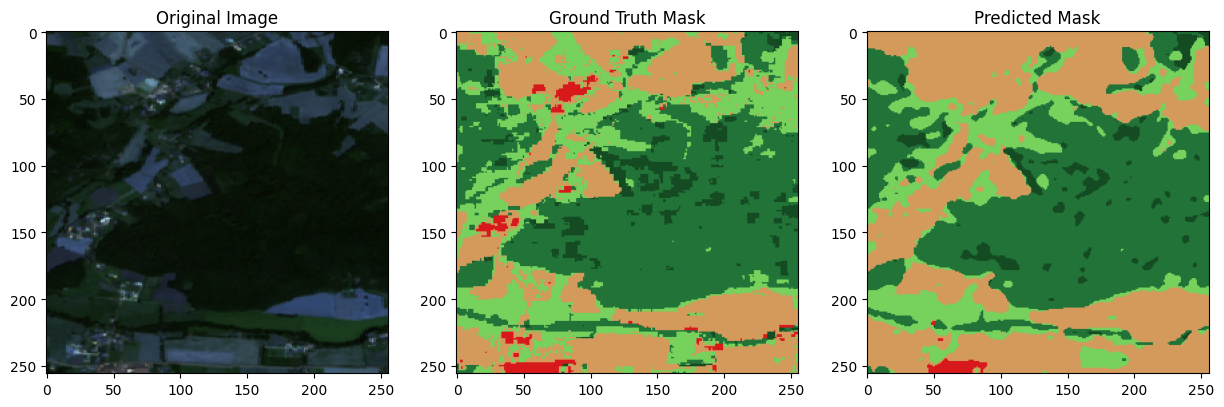

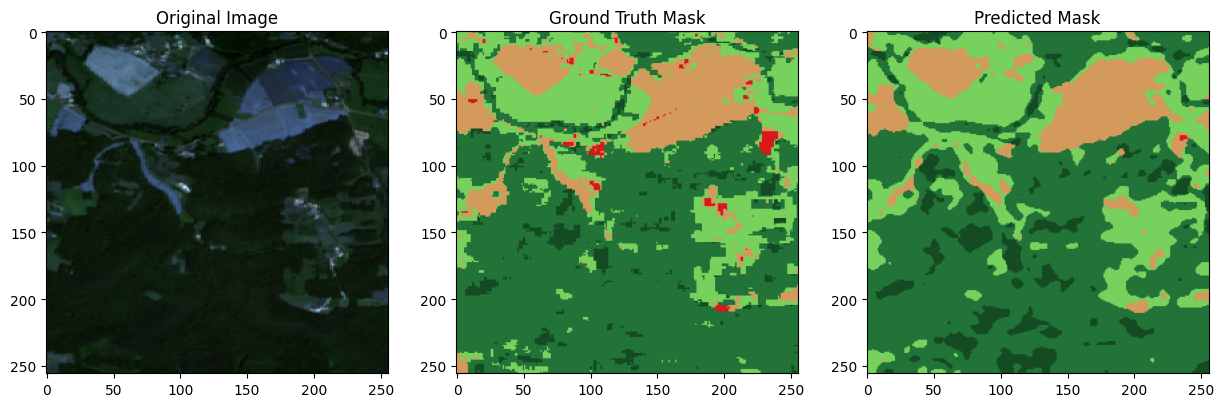

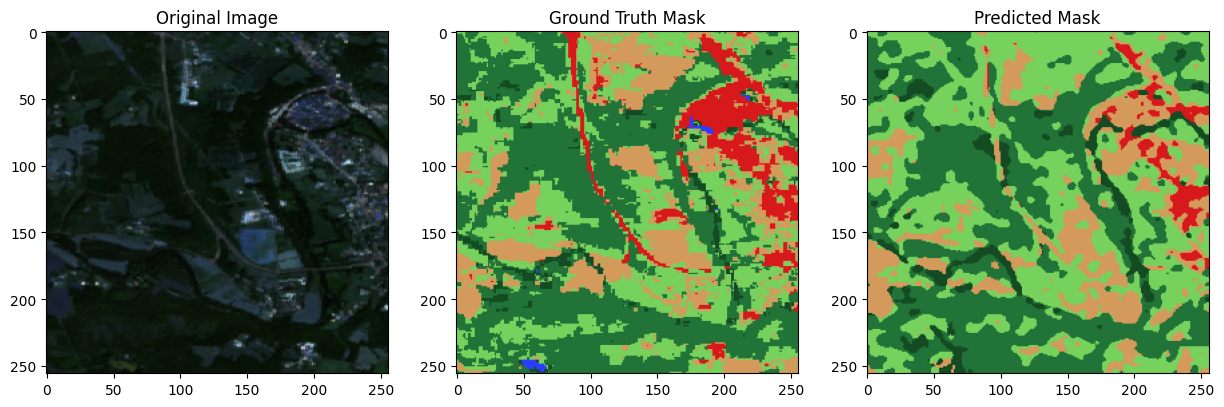

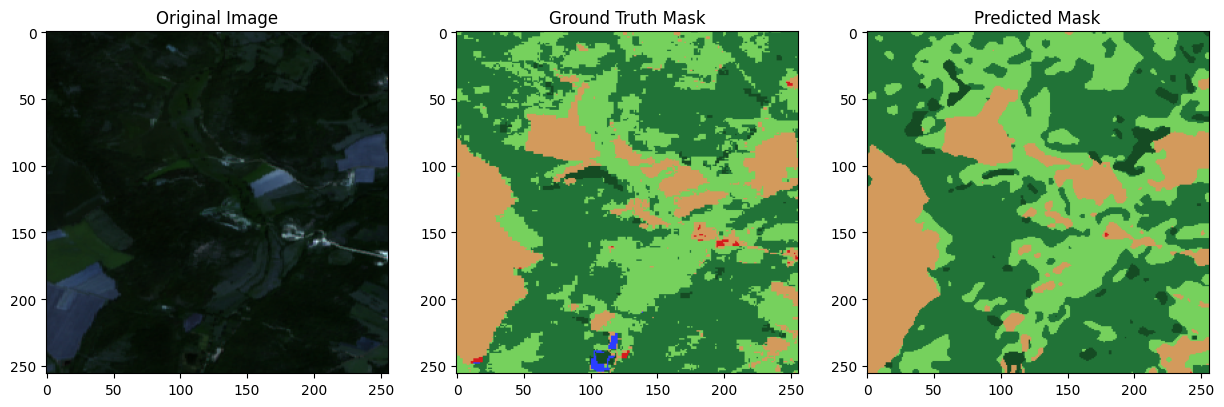

In [31]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Color palette
CLASSES_COLORPALETTE = {
    0: [0, 0, 0],
    1: [255, 25, 236],
    2: [215, 25, 28],
    3: [211, 154, 92],
    4: [33, 115, 55],
    5: [21, 75, 35],
    6: [118, 209, 93],
    7: [130, 130, 130],
    8: [255, 255, 255],
    9: [43, 61, 255]
}

# Assuming val_loader is defined in your code
val_inputs, val_targets = next(iter(val_loader))

val_pixel_values = val_inputs.to(device)

# Set the model to evaluation mode
model.eval()
# Perform inference on the validation image
with torch.no_grad():
    val_outputs = model(pixel_values=val_pixel_values)
    val_logits = val_outputs.logits

# Convert logits to predicted labels
_, predicted_labels = torch.max(val_logits, dim=1)

# Visualize the results for one image
for i in range(4):  # Assuming batch size is 4
    plt.figure(figsize=(15, 5))

    # Original image
    original_image = val_inputs[i].permute(1, 2, 0).cpu().numpy()
    original_image = original_image[:, :, :3] # Utilisez seulement les 3 premiers canaux et normalisez à [0, 1]
    original_image=original_image / original_image.max()
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    # Ground truth mask
    plt.subplot(1, 3, 2)
    ground_truth_mask = val_targets[i].cpu().numpy()
    ground_truth_mask_rgb = np.zeros((ground_truth_mask.shape[0], ground_truth_mask.shape[1], 3), dtype=np.uint8)
    for cls, color in CLASSES_COLORPALETTE.items():
        ground_truth_mask_rgb[ground_truth_mask == cls] = color
    plt.imshow(ground_truth_mask_rgb)
    plt.title("Ground Truth Mask")

    # Predicted mask
    plt.subplot(1, 3, 3)
    # Rescale logits to original image size
    upsampled_logits = torch.nn.functional.interpolate(val_logits, size=val_pixel_values.shape[2:], mode='bicubic')
    # Apply argmax on the class dimension
    seg = upsampled_logits.argmax(dim=1)[i].cpu().numpy()
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(CLASSES_COLORPALETTE.values()):
        color_seg[seg == label] = color


    # Show image + mask
    img = original_image  + color_seg
    img = img.astype(np.uint8)

    plt.imshow(img)
    plt.title("Predicted Mask")

    plt.show()


In [35]:
# Estimation du vecteur Y = [no_data, clouds, artificial, cultivated, broadleaf, coniferous, herbaceous, natural, snow, water]
def get_Y(mask2d):
  occurrences = np.bincount(mask2d.flatten(), minlength=10)
  Y = occurrences / np.sum(occurrences)
  return Y

def klmetric(y_t, y_p, eps):
  sum = 0
  for i in range(len(y_t)):
    sum += (y_t[i]+eps)*np.log((y_t[i] + eps) / (y_p[i] + eps))
  return sum

In [36]:
def mesure_on_batch(batch_gt, batch_predi, batch_size=4):
  mean = 0
  for i in range(batch_size):
    Y_pred = get_Y(batch_gt[i].cpu().numpy())
    Y_truth = get_Y(batch_predi[i].cpu().numpy())
    mean += klmetric(Y_truth, Y_pred, 10e-8)
  return mean / batch_size

def mesure_on_dataloader(test_dataloader):

  mean = 0
  for i in range(len(test_dataloader)):
    test_inputs, test_targets = next(iter(val_loader))
    test_pixels_values = test_inputs.to(device)
    model.eval()
    with torch.no_grad():
      test_outputs = model(pixel_values=test_pixels_values)
      test_logits = test_outputs.logits

    _, predicted_labels = torch.max(test_logits, dim=1)

    mean += mesure_on_batch(test_targets, predicted_labels)

  return mean / len(test_dataloader)

In [37]:
mesure_on_dataloader(val_loader)

0.037468126118005644